In [142]:
import subprocess
from multiprocessing import Pool
import os
from itertools import product,repeat
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import spline
from scipy.ndimage.filters import gaussian_filter1d
from scipy import stats
#import statsmodels.api as smdl
%run averaging.ipynb
%run optimize_slope.ipynb

In [76]:
area_er = 2*(3.9+0.1+0.1*0.1+3.9*0.1)
vol_er = (3.9*0.1*0.1)
vol_cyt = (4.0*0.5*0.5-vol_er)
vol_tot = vol_cyt + vol_er
N_avo=6.0221409e23

In [77]:
def write_mdl(file_name,outfolder,iterations,ic,sf,sm,kleak,serca_frac,write=True):
    ftext = """sprintf(my_seed,"%05g",SEED)

    iterations = e3

    INCLUDE_FILE = "../outputLoc.mdl"
    INCLUDE_FILE = "../initialization.mdl"
    INCLUDE_FILE = "parameters.mdl"
    /* Modifications in Parameters */
        VDCC_number_presynaptic = 40

        n_Glu_neuron =  1 //2000
        GluT_density_astrocyte = 0.1 //1000

        ca_conc_presynaptic_er = e-6     //initial ER conc specified here!!!!!
        //ryr_number_presynaptic = 0 //no RYR

    f =                                 //SERCA parameter adjustments here!!!!!!!!!!

    sm = //multiply all serca parameters

    /*Initial SERCA fractions*/
    serca_x1_feq = 
    serca_x1a_feq = 
    serca_x2_feq = 
    serca_y1_feq = 
    serca_y1a_feq = 
    serca_y2_feq = 

    INCLUDE_FILE = "rxn_rate_constants.mdl"
    /* Modifications in Reaction Rate Constants */

    k_ER_leak = 


    /* Output Folder */
            //isi = "40"
        sprintf(VDCC, "%g", VDCC_number_presynaptic)
        sprintf(f_mult, "%g", f) 
        sprintf(s_mult, "%g", sm)
        sprintf(kleak, "%g", k_ER_leak)
        sprintf(init_er_conc, "%g", ca_conc_presynaptic_er*1e6)   	
        fname = 

        output_folder = outputLoc & "ppf/" & fname & "/sm" & s_mult & "/" & f_mult & "/" & init_er_conc & "/kleak" & kleak & "/s_" & my_seed

    /* Rates for P/Q-type Voltage Dependent Calcium Channels */
    /* From Bischoffberger et al., 2005, , Biophys. J.*/

        k_VDCC_PQ_C01 = 0
        k_VDCC_PQ_C12 = 0
        k_VDCC_PQ_C23 = 0
        k_VDCC_PQ_C34 = 0
        k_VDCC_PQ_C43 = 0
        k_VDCC_PQ_C32 = 0
        k_VDCC_PQ_C21= 0
        k_VDCC_PQ_C10 = 0
        k_VDCC_PQ_Ca = 0

    INCLUDE_FILE = "triggered_release.inc.mdl"

    INCLUDE_FILE = "rxn_outputRS.mdl"
    //INCLUDE_FILE = "viz_output.mdl"
    """
    ftext=ftext.replace('k_ER_leak = ', 'k_ER_leak = '+str(kleak))
    ftext=ftext.replace('iterations = ', 'iterations = '+str(iterations))
    ftext=ftext.replace('sm = ', 'sm = '+str(sm))
    ftext=ftext.replace('ca_conc_presynaptic_er = ', 'ca_conc_presynaptic_er = '+str(ic))
    ftext=ftext.replace('f = ','f = '+str(sf))
    ftext=ftext.replace('fname = ','fname = '+'"'+str(outfolder)+'"')
    for i,p in enumerate(['x1','x1a','x2','y2','y1a','y1']):
        old="serca_"+p+"_feq = "
        new="serca_"+p+"_feq = "+str(serca_frac[i])
        ftext=ftext.replace(old,new)
    if write:
        with open(file_name,'w') as wfile:
            wfile.write(ftext)

      

In [68]:
#Find good clamp conc for 250uM

%run get_SERCA_equilibrium.ipynb

final_conc=500
sf=2
initial_conc=np.arange(260,274,3)
serca_mult=[0]
seed_num=20
#leak_mult=[1,5,10,50,100]
k_leaks=[0]#list(np.arange(2500,15000,1250))#[1,5,10,50,100]


folder="/home/kabir/Project/tripartiteSynapse/brute500_8/"
outfolder="brute11"


iterations=100
fnames=[]

for (sm,k_leak,ic) in product(serca_mult,k_leaks,initial_conc):
    serca_frac=get_SERCA_equilibrium(250)
    file_name=folder+"er_clamp_sm"+str(sm)+"_ic"+str(ic)+"_sf"+str(sf)+"_kleak"+str(k_leak)+".mdl"
    fnames.append(file_name)
    write_mdl(file_name,outfolder,iterations,ic,sf,sm,k_leak,serca_frac,write=True)
        

/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [106]:
#Generate mdls for checking relation of leak parameter and slope at 250uM

%run get_SERCA_equilibrium.ipynb

final_conc=500
sf=2
initial_conc=[250]
serca_mult=[0]
seed_num=20
#leak_mult=[1,5,10,50,100]
k_leaks=list(np.arange(2500,20000,2500))#[1,5,10,50,100]


folder="/home/kabir/Project/tripartiteSynapse/brute500_8/"
outfolder="brute11"


iterations=1500
fnames=[]

for (sm,k_leak,ic) in product(serca_mult,k_leaks,initial_conc):
    serca_frac=get_SERCA_equilibrium(ic)
    file_name=folder+"er_clamp_sm"+str(sm)+"_ic"+str(ic)+"_sf"+str(sf)+"_kleak"+str(k_leak)+".mdl"
    fnames.append(file_name)
    write_mdl(file_name,outfolder,iterations,ic,sf,sm,k_leak,serca_frac,write=True)
        

/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [112]:
#Generate mdls for checking relation of sm and slope at 250uM      

%run get_SERCA_equilibrium.ipynb
#checking slope for sf=2, various sm, at 250uM
final_conc=500
sf=2
initial_conc=[250]
serca_mult=np.arange(30,300,30)#[30,80,110,140,200,300]#[50,100,125,150]
seed_num=20

folder="/home/kabir/Project/tripartiteSynapse/brute500_8/"
outfolder="brute11"

k_leaks=[0]
iterations=1500
fnames=[]

for (sm,k_leak,ic) in product(serca_mult,k_leaks,initial_conc):
    serca_frac=get_SERCA_equilibrium(ic)
    file_name=folder+"er_clamp_sm"+str(sm)+"_ic"+str(ic)+"_sf"+str(sf)+"_kleak"+str(k_leak)+".mdl"
    fnames.append(file_name)
    write_mdl(file_name,outfolder,iterations,ic,sf,sm,k_leak,serca_frac,write=True)
        

/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [118]:
#write run.sh
with open(folder+'run.sh','w') as f:
    for name in fnames:
            f.write("sed --i 's/^#PBS -J.*/#PBS -J 1-"+str(seed_num)+"/' pbs.py\n")
            f.write("qsub -N "+name.replace('_sf2_kleak0.mdl','').replace(folder+'er_clamp_','')+" -v I='"+name.replace('/kabir/Project/','/subhadra/kabir/')+"' pbs.py\n")
            f.write("\n")

In [108]:
len(fnames)

7

In [119]:
#sync script files to cluster
p=subprocess.call(["rsync","-arhP",folder[:-1],"subhadra@192.168.1.244:/home/subhadra/kabir/tripartiteSynapse/"])

In [181]:
#sync data back to this system
p=subprocess.call(["rsync","-arhP","subhadra@192.168.1.244:/storage/subhadra/kabir/output/ppf/brute11","/data/kabir/output/ppf/"])

In [103]:
%run averaging.ipynb
#checking refilling times for 500 sf=2
data_locs=[]

sf=2
initial_conc=np.arange(260,274,3)
serca_mult=[0]
#leak_mult=[1,5,10,50,100]

k_leaks=[0]#list(np.arange(2500,15000,1250))#[1,5,10,50,100]
for (sm,ic,k_leak) in product(serca_mult,initial_conc,k_leaks):
    #print(sm,ic,k_leak)
    loc="/data/kabir/output/ppf/brute11/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/kleak"+str(k_leak)+"/"
    data_locs.append(loc)
    #print(loc)
p=Pool(7)
data_list=p.map(averager,data_locs)
sm_len=len(serca_mult)
ic_len=len(initial_conc)

/data/kabir/output/ppf/brute11/sm0/2/272/kleak0/
/data/kabir/output/ppf/brute11/sm0/2/263/kleak0/
/data/kabir/output/ppf/brute11/sm0/2/269/kleak0/
/data/kabir/output/ppf/brute11/sm0/2/260/kleak0/
/data/kabir/output/ppf/brute11/sm0/2/266/kleak0/


In [104]:
"""data={}
for i,sm in enumerate(serca_mult):
    data[sm]={}
    for j,ic in enumerate(initial_conc):
        #print('i=',i,'j=',j)
        #print(i*sm_len+j)
        data[sm][ic]=data_list[i*sm_len+j]
        #data[sm][ic].T[1]*=1e15/N_avo/vol_er*1e6"""
#load data 500
data1={}
sm=0
sf=2
#ic=250
for ic in initial_conc:
    data_file='/data/kabir/output/ppf/brute11/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/kleak'+str(k_leak)+'/Average/ca.dat'
    #print data_file
    data1[ic]=np.loadtxt(data_file)
    data1[ick_leak_slope].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar

Average for ic=260 244.1516848686863
Average for ic=263 246.9919492255604
Average for ic=266 249.7705257343039
Average for ic=269 252.58114156533844
Average for ic=272 255.4164260480828
[266.23221704]


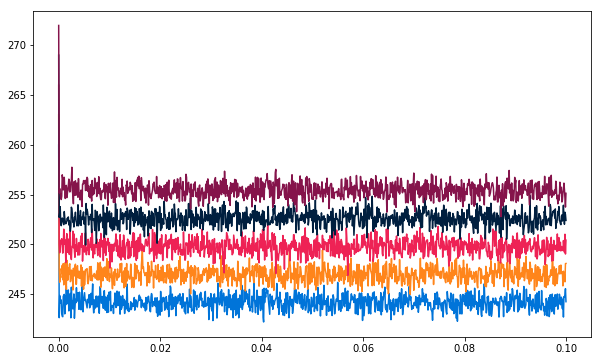

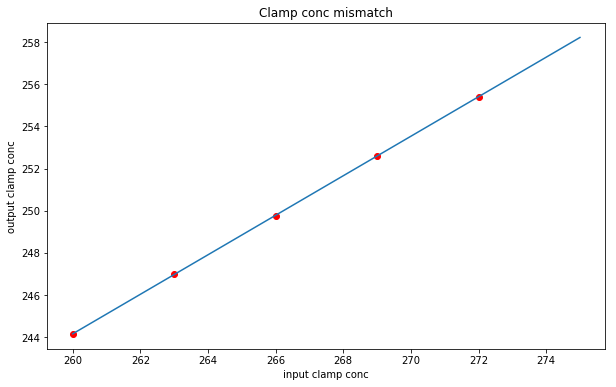

In [105]:
#plot sf=2, sm= for different ic

color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
sf=2

#sm=70
#ic=300
average_conc={'input':[],'output':[]}
plt.figure(figsize=(10,6))
for i,ic in enumerate(initial_conc):
    ydata=data1[ic].T[1]
    xdata=data1[ic].T[0]
    average_conc['input'].append(ic)
    average_conc['output'].append(np.average(ydata[20:]))
    print("Average for ic="+str(ic)+"",np.average(ydata[20:])) 
    plt.plot(xdata,ydata,color=color[i%12],label='k_leak='+str(ic))
    
plt.figure(figsize=(10,6))        
plt.plot(average_conc['input'],average_conc['output'],'ro')
plt.ylabel("output clamp conc")
plt.xlabel("input clamp conc")
plt.title("Clamp conc mismatch")
p=np.polyfit(average_conc['input'],average_conc['output'],1)
x=np.linspace(260,275,100)
plt.plot(x,np.polyval(p,x))
p[-1]=p[-1]-250
soln=np.roots(p)
print(soln)
#plt.savefig('/home/kabir/Project/plots/brute6/er_clamp_mismatch.eps')
a="""    ydelta=10
    conc=250
    argmin,argmax=np.argmin(abs(ydata-(conc+ydelta))),np.argmin(abs(ydata-(conc-ydelta)))
    #print(argmin,argmax)
    #print(ydata[argmin:argmax])
    #print(xdata[argmin:argmax])
    
    p=np.polyfit(xdata[argmin:argmax],ydata[argmin:argmax],1)
    x=np.linspace(0,0.04,100)
    #plt.plot(x,np.polyval(p,x),color=color[i])
    dp=np.polyder(p)
    p[-1]=p[-1]-conc
    t=np.roots(p)
    t=[time for time in t if xdata[argmin] <= time <= xdata[argmax]][0]
    #print("t=",t)
    slope=np.polyval(dp,t)
    #print("Slope = ",slope,"k_leak = ",k_leak)
    slope_kleak['slope'].append(slope)
    slope_kleak['k_leak'].append(k_leak)

#for key in more_slope_conc.keys():
    #more_slope_conc[key]=np.array(more_slope_conc[key])
plt.xlabel("time(sec)")
plt.ylabel("Ca2+ ER conc (uM)")
plt.legend()
#plt.ylim((0,275))    
#plt.xlim((0,0.04))
#plt.savefig('/home/kabir/Project/plots/brute6/leak_rate.eps')""""""
#plt.savefig('/home/kabir/Project/midsemreport_spring2019/new_sm.eps')
plt.figure(figsize=(10,6))
plt.plot(slope_kleak['k_leak'],slope_kleak['slope'],'ro')
plt.ylabel("dC/dt at 250uM")
plt.xlabel("k_leak")
plt.title("k_leak and slope at 250uM")
p=np.polyfit(slope_kleak['k_leak'],slope_kleak['slope'],4)
x=np.linspace(0,70000,100)
plt.plot(x,np.polyval(p,x))
plt.xlim((0,70000))
plt.ylim((-800,0))
#plt.savefig('/home/kabir/Project/plots/brute6/k_leak_slope.eps')
p1=p
p1[-1]=p1[-1]+80
print(" for slope = 60:",np.roots(p1))
p2=p
p2[-1]=p2[-1]+35
print("k_leak for slope = 25:",np.roots(p2))#"""

# This is for leak parameter slope at 250uM

In [184]:
%run averaging1.ipynb
#checking refilling times for 500 sf=2
final_conc=500
sf=2

data_locs=[]

initial_conc=[250]
serca_mult=[0]
seed_num=20
k_leaks=k_leaks=list(np.arange(2500,20000,2500))
data_type=['ca.dat','pmca&leak_ca_flux.dat']
columns={}
columns[data_type[0]],columns[data_type[1]]=3,3
for (sm,ic,k_leak) in product(serca_mult,initial_conc,k_leaks):
    #print(sm,ic,k_leak)
    loc="/data/kabir/output/ppf/brute11/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/kleak"+str(k_leak)+"/"
    data_locs.append(loc)
    #print(loc)
#print(list(product(data_locs,data_type,[3])))
p=Pool(7)
data_list=p.starmap(averager,product(data_locs,data_type,[3]))
sm_len=len(serca_mult)
ic_len=len(initial_conc)

In [189]:
"""data={}
for i,sm in enumerate(serca_mult):
    data[sm]={}
    for j,ic in enumerate(initial_conc):
        #print('i=',i,'j=',j)
        #print(i*sm_len+j)
        data[sm][ic]=data_list[i*sm_len+j]
        #data[sm][ic].T[1]*=1e15/N_avo/vol_er*1e6"""
#load data 500
data1={}
sm=0
sf=2
#ic=250
for k_leak in k_leaks:
    data_file='/data/kabir/output/ppf/brute11/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/kleak'+str(k_leak)+'/Average/pmca&leak_ca_flux.dat'
    #print data_file
    data1[k_leak]=np.loadtxt(data_file)
    #data1[k_leak].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar

 for slope = 60: [-404.90918469]
k_leak for slope = 25: [-556.50108651]


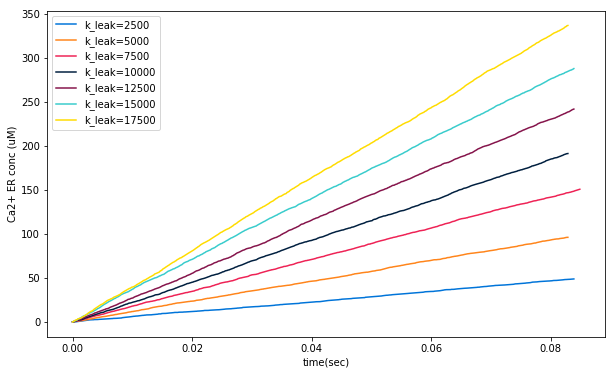

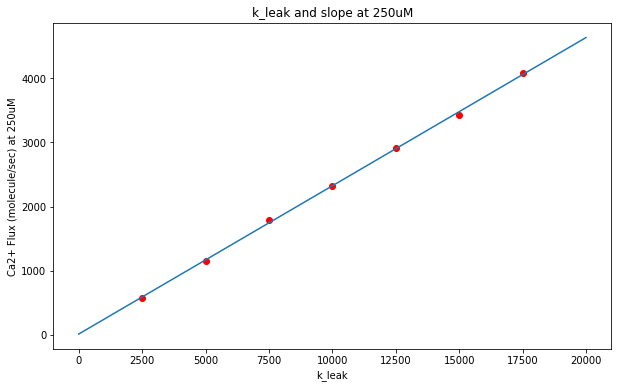

In [196]:
#plot sf=2, sm= for different ic

color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
sf=2
ic=250
#sm=70
#ic=300
slope_kleak={'slope':[],'k_leak':[]}
plt.figure(figsize=(10,6))
for i,k_leak in enumerate(k_leaks):
    ydata=data1[k_leak].T[1]
    xdata=data1[k_leak].T[0]
    
    plt.plot(xdata,ydata,color=color[i%12],label='k_leak='+str(k_leak))
        
        

    
    p=np.polyfit(xdata,ydata,1)
    x=np.linspace(0,0.08,100)
    slope_kleak['slope'].append(p[0])
    slope_kleak['k_leak'].append(k_leak)

#for key in more_slope_conc.keys():
    #more_slope_conc[key]=np.array(more_slope_conc[key])
plt.xlabel("time(sec)")
plt.ylabel("Ca2+ ER conc (uM)")
plt.legend()
#plt.ylim((0,275))    
#plt.xlim((0,0.04))
#plt.savefig('/home/kabir/Project/plots/brute6/leak_rate.eps')""""""
#plt.savefig('/home/kabir/Project/midsemreport_spring2019/new_sm.eps')
plt.figure(figsize=(10,6))
plt.plot(slope_kleak['k_leak'],slope_kleak['slope'],'ro')
plt.ylabel("Ca2+ Flux (molecule/sec) at 250uM")
plt.xlabel("k_leak")
plt.title("k_leak and slope at 250uM")
p=np.polyfit(slope_kleak['k_leak'],slope_kleak['slope'],1)
x=np.linspace(0,20000,100)
plt.plot(x,np.polyval(p,x))
#plt.xlim((0,70000))
#plt.ylim((-800,0))
plt.savefig('/home/kabir/Project/plots/brute6/k_leak_slope_clamp.eps')
p1=p
p1[-1]=p1[-1]+80
print(" for slope = 60:",np.roots(p1))
p2=p
p2[-1]=p2[-1]+35
print("k_leak for slope = 25:",np.roots(p2))#"""

# Below is for sm parameter and slope at 250uM

In [213]:
%run averaging1.ipynb
#checking refilling times for 500 sf=2
final_conc=500
sf=2
initial_conc=[250]
serca_mult=np.arange(30,300,30)
data_locs=[]
k_leaks=[0]
data_type=['serca_ca_flux.dat']

for (sm,ic,k_leak) in product(serca_mult,initial_conc,k_leaks):
    #print(sm,ic,k_leak)
    loc="/data/kabir/output/ppf/brute11/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/kleak"+str(k_leak)+"/"
    data_locs.append(loc)
    #print(loc)
#print(list(product(data_locs,data_type,[3])))
p=Pool(7)
data_list=p.starmap(averager,product(data_locs,data_type,[1]))
sm_len=len(serca_mult)
ic_len=len(initial_conc)

In [214]:
"""data={}
for i,sm in enumerate(serca_mult):
    data[sm]={}
    for j,ic in enumerate(initial_conc):
        #print('i=',i,'j=',j)
        #print(i*sm_len+j)
        data[sm][ic]=data_list[i*sm_len+j]
        #data[sm][ic].T[1]*=1e15/N_avo/vol_er*1e6"""
#load data 500
ic=250
data2={}
serca_mult=np.arange(30,300,30)
initial_conc=[250]
k_leaks=[0]
for sm in serca_mult:
    data2[sm]={}
    for ic in initial_conc:
        for k_leak in k_leaks:
            data_file='/data/kabir/output/ppf/brute11/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/kleak'+str(k_leak)+'/Average/serca_ca_flux.dat'
            #print data_file
            data2[sm][ic]=np.loadtxt(data_file)
            #data2[sm][ic].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar

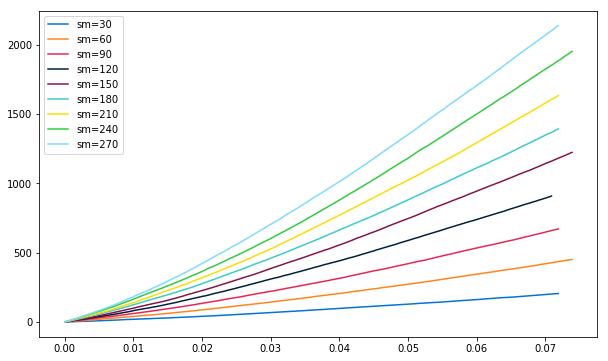

In [215]:
#plot sf=2, sm= for different ic

color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
sf=2
ic=250
#sm=70
#ic=300
slope_sm={'slope':[],'sm':[]}
plt.figure(figsize=(10,6))
for i,sm in enumerate(serca_mult):
    ydata=data2[sm][ic].T[1]
    xdata=data2[sm][ic].T[0]
    #ydata = gaussian_filter1d(ydata, sigma=300)
    plt.plot(xdata,ydata,color=color[i],label='sm='+str(sm))
plt.legend()
a= """#slope,conc=eval_slope_conc(0.75,xdata,ydata,0.70)
    p=np.polyfit(xdata,ydata,3)
    x=np.linspace(0,1.5,100)
    plt.plot(x,np.polyval(p,x),color=color[i])
    dp=np.polyder(p)
    conc=250
    p[-1]=p[-1]-conc
    t=np.roots(p)
    slope=np.polyval(dp,t[2])
    print("Slope = ",slope," Conc = ",conc)
    slope_sm['slope'].append(slope)
    slope_sm['sm'].append(sm)
    

#for key in more_slope_conc.keys():
    #more_slope_conc[key]=np.array(more_slope_conc[key])
    
plt.legend()
#plt.ylim((150,250))    
#plt.xlim((0,1.5))
#plt.savefig('/home/kabir/Project/plots/brute6/new_sf_750.eps')#
#plt.savefig('/home/kabir/Project/midsemreport_spring2019/new_sm.eps')

plt.figure(figsize=(10,6))
plt.xlabel("sm")
plt.ylabel("dC/dt at 250uM")
slope_sm['sm'].append(70)
slope_sm['slope'].append(38.242551901)
plt.plot(slope_sm['sm'],slope_sm['slope'],'ro')
p=np.polyfit(slope_sm['sm'],slope_sm['slope'],1)
x=np.linspace(50,150,100)
plt.plot(x,np.polyval(p,x))

np.polyval(p,300)#"""

In [295]:
#average,full refilling
initial_conc=[0]

serca_mult=[70,100,150]
serca_f=[2]
sf=serca_f[0]

#serca_mult=[1]#[3,6,9,12,15]#[1]
#serca_f=[2,2.2,2.4,2.6,2.8,2.9,3,3.1,3.2,3.4,3.6,3.8,4]

data_locs=[]
for sm in serca_mult:
    for ic in initial_conc:
        #averager("/data/kabir/output/ppf/brute9/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")
        data_locs.append("/data/kabir/output/ppf/brute9/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")
p=Pool(7)
data_list=p.map(averager,data_locs)
sm_len=len(serca_mult)
ic_len=len(initial_conc)

In [296]:
#load data, full refilling
data={}
initial_conc=[0]

serca_mult=[70,100,150]
serca_f=[2]
sf=serca_f[0]
seed={70:8,100:4,150:2}
for sm in serca_mult:
    data[sm]={}
    for ic in initial_conc:
        data_file='/data/kabir/output/ppf/brute9/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/s_0000'+str(seed[sm])+'/dat/ca.dat'
        #print data_file
        data[sm][ic]=np.loadtxt(data_file)
        data[sm][ic].T[3]*=1e15/N_avo/vol_er*1e6 #micromolar

In [297]:
def exp_fit(x,c,tau):
    A=500
    return A*(1-np.exp(-(x-c)/tau))

In [298]:
def eval_slope_conc(t,xdata,ydata,range):
    tstep=xdata[1]-xdata[0]
    delta_t=range
    lower,upper=int(max(0,(t-delta_t)/tstep)),int(min(len(xdata),(t+delta_t)/tstep))
    a, b, r_value, p_value, std_err= stats.linregress(xdata[lower:upper],ydata[lower:upper])
    conc=a*t+b

    #print('conc=',conc,'tau=',tau,'error=',std_err)
    return a,conc

a= 0.3842133105762622 
b= -65.432415126828


NameError: name 'more_slope_conc' is not defined

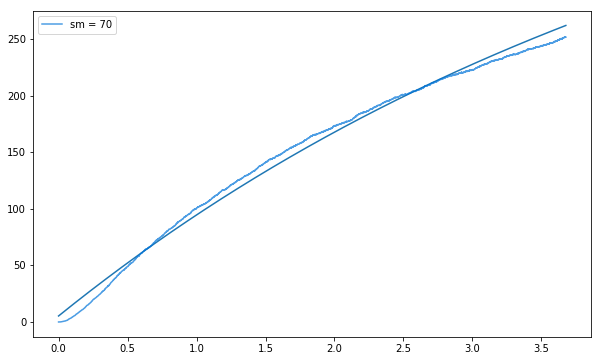

In [299]:
color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]

ic=0
plt.figure(figsize=(10,6))
for i,sm in enumerate([70]):
    ydata=data[sm][ic].T[3]
    xdata=data[sm][ic].T[0]
    popt,pcov=curve_fit(exp_fit,xdata,ydata,p0=[0,5])
    plt.plot(xdata,exp_fit(xdata,*popt))
    plt.plot(xdata,ydata,color=color[i%12],label='sm = '+str(sm), alpha=0.7)
plt.legend()

plt.figure(figsize=(10,6))
for sm in [70]:
    slope_conc_data={'slope':[],'conc':[]}
    ydata=data[sm][ic].T[3]
    xdata=data[sm][ic].T[0]
    times=[1,1.5,2,2.5]
    for t in times: 
        slope,conc=eval_slope_conc(t,xdata,ydata,1)
        slope_conc_data['slope'].append(slope)
        slope_conc_data['conc'].append(conc)
    for key in slope_conc_data.keys():
        slope_conc_data[key]=np.array(slope_conc_data[key])
    xdata,ydata=500-slope_conc_data['conc'],slope_conc_data['slope']
    #plt.plot(xdata,ydata,'ro')
    a, b, r_value, p_value, std_err= stats.linregress(xdata,ydata)
    print('a=',a,'\nb=',b)
xdata=500-np.concatenate((slope_conc_data['conc'],more_slope_conc['conc']))
ydata=np.concatenate((slope_conc_data['slope'],more_slope_conc['slope']))
plt.plot(xdata,ydata,'ro',label="Data for sm=70")

def poly(x,A,B,C,D):
    return A*x**3+B*x**2+C*x+D
    #return x**A+B

popt,pcov=curve_fit(poly,xdata,ydata)
x=np.linspace(0,500,100)
y=spline(xdata, ydata, x, order=3, kind='smoothest')
plt.plot(x,poly(x,*popt),label="Cubic polynomial: [A B C D]="+str(popt))
print(popt)
#plt.xlim(())
plt.title("Slope vs 500-C for sm=70, sf=2")
plt.legend()
plt.xlabel("A-conc")
plt.ylabel("dC/dt")
plt.savefig('/home/kabir/Project/plots/brute6/slope_conc_sm70.eps')




In [37]:
def max_file_len(data_loc):
    seed_folders=os.listdir(data_loc)
    if "Average" in seed_folders:
        seed_folders.remove("Average")
    print(seed_folders)
    for s in seed_folders:
        file_name=os.path.join(data_loc,os.path.join(s+'/dat/ca.dat'))
        print(s,file_len(file_name))

In [38]:
def file_len(fname):
    i=-1
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [40]:
max_file_len("/data/kabir/output/ppf/brute11/sm240/2/250/0/")

[]


In [35]:
a= 0.3901029977136642 
b= -67.62046808120242

serca_conc_tot = 15e-6
serca_number_presynaptic=serca_conc_tot*vol_cyt/(1e15/6.02205e23)
leak_number=serca_number_presynaptic/10

ER_conc_rate=a*250+b #in micromolar per sec
serca_flux=ER_conc_rate*1e-6*vol_er*1e-18*1e3*N_avo#moles per sec *N_avo
k_leak=serca_flux/leak_number/250e-6
print("SERCA influx =",serca_flux,"Ca2+ ions per sec")
print("Leak number =",leak_number)
print("k_leak =",k_leak)

SERCA influx = 702.3658899155432 Ca2+ ions per sec
Leak number = 868.0785075
k_leak = 3236.4164478086363


In [33]:
serca_conc_tot = 15e-6
presynaptic_vol=(4*0.5*0.5-vol_er)
serca_number_presynaptic=serca_conc_tot*presynaptic_vol/(1e15/6.02205e23)
leak_number=serca_number_presynaptic/10
presynaptic_ER_leak_conc=leak_number/(vol_er*1e-15)/6.02205e23 #molarity
ER_leak_density_presynaptic = leak_number/area_er



868.0785075


In [112]:
max_file_len("/data/kabir/output/ppf/brute10/sm0/2/275/100")

['s_00012', 's_00014', 's_00010', 's_00008', 's_00015', 's_00017', 's_00011', 's_00009', 's_00003', 's_00001', 's_00020', 's_00018', 's_00013', 's_00019', 's_00006', 's_00002', 's_00007', 's_00016', 's_00004', 's_00005']
s_00012 15002
s_00014 15002
s_00010 15002
s_00008 15002
s_00015 15002
s_00017 15002
s_00011 15002
s_00009 15002
s_00003 15002
s_00001 15002
s_00020 15002
s_00018 15002
s_00013 15002
s_00019 15002
s_00006 15002
s_00002 15002
s_00007 15002
s_00016 15002
s_00004 15002
s_00005 15002


In [ ]:
def slope_from_conc(conc,xdata,ydata,polorder):
    p=np.polyfit(xdata,ydata,polorder)
    #x=np.linspace(0,1.5,100)
    #plt.plot(x,np.polyval(p,x),color=color[i])
    dp=np.polyder(p)
    p[-1]=p[-1]-conc
    t=np.roots(p)
    slope=np.polyval(dp,t[2])
    #print("Slope = ",slope," Conc = ",conc)
    slope_sm['slope'].append(slope)
    slope_sm['sm'].append(sm)
    return 

In [176]:
p=[ 8.56400156e-07, -1.07825697e-04, 1.28255652e-01, -4.63507474e-01]
np.polyval(p,250)

38.242551901

In [195]:
x=np.array([1,2,3,4])
conc=2.2
arg=np.argmin(abs(x-conc)
print(arg)

1


In [262]:
0.62*1e5

62000.0

In [263]:
np.arange(60000,70000,1000)

array([60000, 61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000,
       69000])

In [150]:
def f(a,b,c):
    return a+b+c
p=Pool(7)
p.starmap(f,product([1,2],[2,2],[2,3]))

[5, 6, 5, 6, 6, 7, 6, 7]